In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


### GPU Berechnung aktivieren

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


Pfade der Trainings/Validierungs/Test Daten

In [15]:
train_path = 'final/train'
valid_path = 'final/valid'
test_path = 'final/test'

In [16]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Melanoma', 'Nevus'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Melanoma', 'Nevus'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Melanoma', 'Nevus'], batch_size=10, shuffle=False)

Found 14896 images belonging to 2 classes.
Found 7267 images belonging to 2 classes.
Found 6394 images belonging to 2 classes.


## Build and train CNN

In [8]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)

Epoch 1/20
1474/1474 - 341s - loss: 0.6620 - accuracy: 0.6571 - val_loss: 0.6356 - val_accuracy: 0.6623
Epoch 2/20
1474/1474 - 342s - loss: 0.5514 - accuracy: 0.7253 - val_loss: 0.5554 - val_accuracy: 0.7282
Epoch 3/20
1474/1474 - 350s - loss: 0.4904 - accuracy: 0.7650 - val_loss: 0.4962 - val_accuracy: 0.7705
Epoch 4/20
1474/1474 - 347s - loss: 0.4475 - accuracy: 0.7932 - val_loss: 0.4566 - val_accuracy: 0.7788
Epoch 5/20
1474/1474 - 337s - loss: 0.4131 - accuracy: 0.8128 - val_loss: 0.4251 - val_accuracy: 0.7894
Epoch 6/20
1474/1474 - 337s - loss: 0.3830 - accuracy: 0.8339 - val_loss: 0.4819 - val_accuracy: 0.7709
Epoch 7/20
1474/1474 - 337s - loss: 0.3625 - accuracy: 0.8453 - val_loss: 0.4306 - val_accuracy: 0.8073
Epoch 8/20
1474/1474 - 336s - loss: 0.3380 - accuracy: 0.8611 - val_loss: 0.4351 - val_accuracy: 0.7951
Epoch 9/20
1474/1474 - 336s - loss: 0.3193 - accuracy: 0.8741 - val_loss: 0.4280 - val_accuracy: 0.7954
Epoch 10/20
1474/1474 - 337s - loss: 0.3011 - accuracy: 0.8827 -

## Predict

In [13]:
predictions = model.predict(x=test_batches, verbose=0)

In [14]:
test_batches.class_indices

{'Melanoma': 0, 'Nevus': 1}

## Plotten der Confusion Matrix

In [14]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
test_batches.class_indices

{'Melanoma': 0, 'Nevus': 1}

Confusion matrix, without normalization
[[2655  547]
 [ 623 2569]]


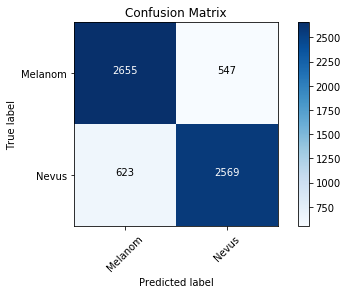

In [17]:
cm_plot_labels = ['Melanom','Nevus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## VGG16

## Nachbauen des VGG16

In [5]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [7]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
vgg16_model.layers[1]

In [6]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Letztes DenseLayer muss unserer Aufgabe entsprechend angepasst sein mit 2 Klassen

In [7]:
model.add(Dense(units=2, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [9]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)

Epoch 1/20
1490/1490 - 1248s - loss: 0.4905 - accuracy: 0.7677 - val_loss: 0.3720 - val_accuracy: 0.8174
Epoch 2/20
1490/1490 - 1317s - loss: 0.3843 - accuracy: 0.8192 - val_loss: 0.3146 - val_accuracy: 0.8492
Epoch 3/20
1490/1490 - 1317s - loss: 0.3579 - accuracy: 0.8354 - val_loss: 0.3304 - val_accuracy: 0.8496
Epoch 4/20
1490/1490 - 1317s - loss: 0.3425 - accuracy: 0.8461 - val_loss: 0.4522 - val_accuracy: 0.7691
Epoch 5/20
1490/1490 - 1317s - loss: 0.4633 - accuracy: 0.7987 - val_loss: 0.3647 - val_accuracy: 0.8351
Epoch 6/20
1490/1490 - 1317s - loss: 0.3324 - accuracy: 0.8529 - val_loss: 0.3165 - val_accuracy: 0.8463
Epoch 7/20
1490/1490 - 1317s - loss: 0.3109 - accuracy: 0.8620 - val_loss: 0.3176 - val_accuracy: 0.8514
Epoch 8/20
1490/1490 - 1315s - loss: 0.3165 - accuracy: 0.8612 - val_loss: 0.3387 - val_accuracy: 0.8409
Epoch 9/20
1490/1490 - 1318s - loss: 0.2859 - accuracy: 0.8760 - val_loss: 0.3475 - val_accuracy: 0.8526
Epoch 10/20
1490/1490 - 1316s - loss: 0.2725 - accuracy

## Prediction

In [11]:
predictions = model.predict(x=test_batches, verbose=0)

Confusion matrix, without normalization
[[2999  203]
 [ 456 2736]]


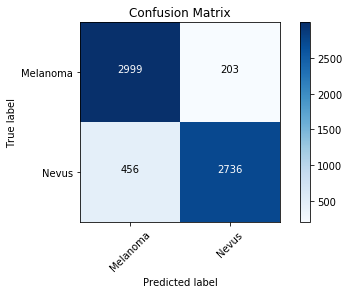

In [13]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Melanoma','Nevus']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Speichern des Models

In [14]:
model.save('vgg16_224x224.h5')

In [2]:
from tensorflow.keras.models import load_model
new_model = load_model('vgg16_224x224.h5')

In [3]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [4]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory="2data/custom", target_size=(224,224), classes=['Melanoma', 'Nevus'], batch_size=1, shuffle=False)

Found 1 images belonging to 2 classes.


In [5]:
predictions = new_model.predict(x=test_batches, verbose=0)

In [6]:
np.round(predictions)

array([[0., 1.]], dtype=float32)

# Grad-Cam

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [14]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Es werden Layer ab dem letzten Conv-Layer benötigt

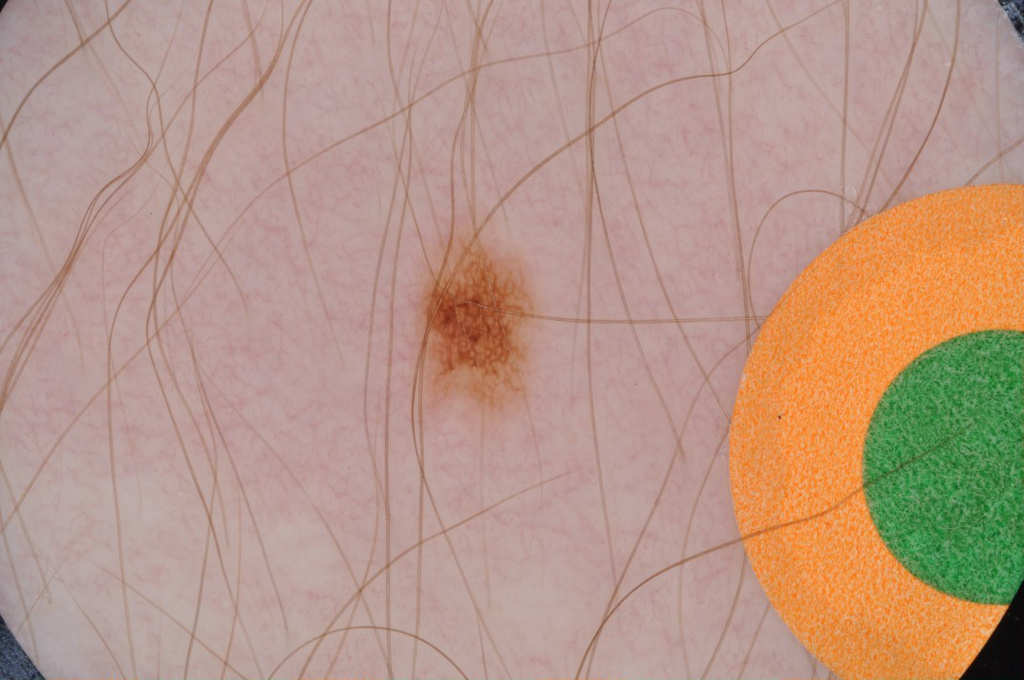

In [16]:
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool",
    "flatten",
    "fc1",
    "fc2",
    "dense",
]

# The local path to our target image
img_path = "ISIC_0001187_downsampled.jpg"

display(Image(img_path))


In [17]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [18]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

In [19]:
# Prepare image
# Print what the top predicted class is
preds = new_model.predict(img_array)
print(preds)



[[4.648854e-08 1.000000e+00]]


array([[0., 1.]], dtype=float32)

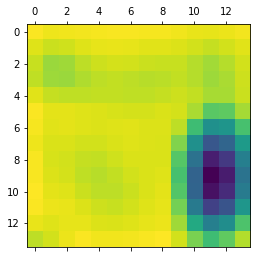

In [24]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, new_model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

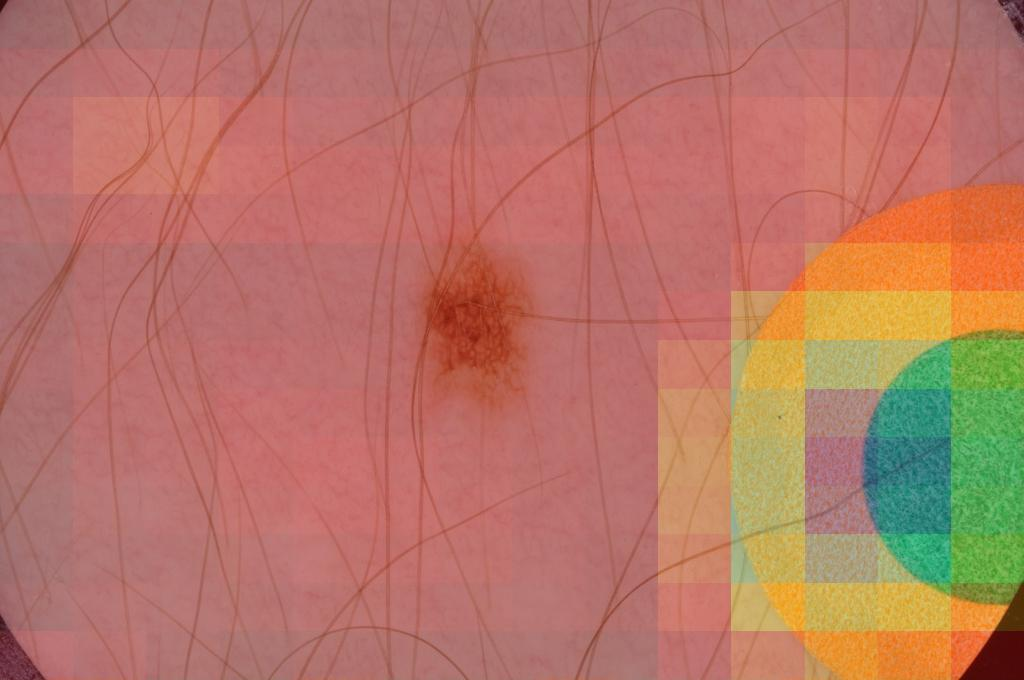

In [31]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


# Plots 

# Simple 


In [ ]:
epochs = [x for x in range (21)]
ones = [1 for i in range (21)]
train_acc = [0,0.7059,0.8245,0.8900,0.9232,0.09461,0.9654,0.9738,0.9777,0.9826,0.9901,0.9900,0.9891,0.9883,0.9952,0.9939,0.9920,0.9952,0.9919,0.9945,0.9922]
train_loss = [0,1.9517,0.3968,0.2681,0.2010,0.1455,0.1009,0.0793,0.0713,0.0554,0.0332,0.0353,0.0344,0.0381,0.0211,0.0249,0.0262,0.0169,0.0307,0.0187,0.0328]
valid_acc = [0,0.7754,0.7991,0.7757,0.7948,0.8140,0.8086,0.8078,0.7928,0.8056,0.8010,0.7963,0.7995,0.7881,0.8034,0.7977,0.7937,0.7812,0.7991,0.7966,0.7999]
valid_loss = [0,0.4920,0.4203,0.5237,0.5826,0.5685,0.6793,0.7421,0.7877,0.8754,0.9391,1.0342,1.0397,1.1447,1.1485,1.2954,1.2440,1.3301,1.4307,1.4429,1.2518]
print(len(train_acc))
print(len(train_loss))
print(len(valid_acc))
print(len(valid_loss))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot(epochs,train_acc,'r--',epochs,train_loss,'b--',epochs,valid_loss,'k--',epochs,valid_acc,'g--',epochs,ones, 'k-')
plt.ylabel('Percentage')
plt.xlabel('Epochs')
plt.xlim(0,20)
plt.ylim(0,2)
plt.xticks([0,5,10,15,20])

valid_acc_handle = mpatches.Patch(color='green', label='Validation_Acc')
valid_loss_handle = mpatches.Patch(color='black', label='Validation_Loss')
train_loss_handle = mpatches.Patch(color='blue', label='Train_Loss')
train_acc_handle = mpatches.Patch(color='red', label='Train_Acc')
plt.legend(handles=[train_acc_handle,train_loss_handle,valid_acc_handle,valid_loss_handle],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# VGG16

In [ ]:
epochs = [x for x in range (21)]
ones = [1 for i in range (21)]
train_acc = [0,0.7677,0.8192,0.8354,0.8461,0.7987,0.8529,0.8620,0.8612,0.8760,0.8832,0.8976,0.9115,0.9139,0.9405,0.9513,0.9594,0.9672,0.9698,0.9763,0.9799]
train_loss = [0,0.4905,0.3843,0.3579,0.3425,0.4633,0.3324,0.3109,0.3165,0.2859,0.2725,0.2422,0.2135,0.2151,0.1568,0.1250,0.1088,0.0866,0.0815,0.0737,0.0576]
valid_acc = [0,0.8174,0.8492,0.8496,0.7691,0.8351,0.8463,0.8514,0.8409,0.8526,0.8694,0.8803,0.8683,0.8614,0.8628,0.8753,0.8708,0.8804,0.8880,0.8946,0.8797]
valid_loss = [0,0.3720,0.3146,0.3304,0.4522,0.3647,0.3165,0.3176,0.3387,0.3475,0.2284,0.2700,0.3097,0.3381,0.4017,0.3561,0.3495,0.4115,0.3405,0.3693,0.4054]
print(len(train_acc))
print(len(train_loss))
print(len(valid_acc))
print(len(valid_loss))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot(epochs,train_acc,'r--',epochs,train_loss,'b--',epochs,valid_loss,'k--',epochs,valid_acc,'g--',epochs,ones,"k-")
plt.ylabel('Percentage')
plt.xlabel('Epochs')
plt.xlim(0,20)
plt.ylim(0,2)
plt.xticks([0,5,10,15,20])

valid_acc_handle = mpatches.Patch(color='green', label='Validation_Acc')
valid_loss_handle = mpatches.Patch(color='black', label='Validation_Loss')
train_loss_handle = mpatches.Patch(color='blue', label='Train_Loss')
train_acc_handle = mpatches.Patch(color='red', label='Train_Acc')
plt.legend(handles=[train_acc_handle,train_loss_handle,valid_acc_handle,valid_loss_handle],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# Simple Cleaned

In [ ]:
epochs = [x for x in range (21)]
ones = [1 for i in range (21)]
train_acc = [0,0.7087,0.8197,0.8789,0.8211,0.9512,0.9584,0.9741,0.9805,0.9828,0.9880,0.9893,0.9906,0.9934,0.9901,0.9927,0.9908,0.9937,0.9940,0.9924,0.9968]
train_loss = [0,2,0.4021,0.2853,0.2036,0.1405,0.1154,0.0770,0.0627,0.0579,0.0415,0.0363,0.0410,0.0236,0.0314,0.0292,0.0403,0.0239,0.0224,0.0271,0.0140]
valid_acc = [0,0.7756,0.7936,0.8141,0.8059,0.7923,0.8175,0.8191,0.8069,0.8137,0.8091,0.8098,0.8204,0.8153,0.8114,0.8085,0.8244,0.8246,0.8120,0.8034,0.8182]
valid_loss = [0,0.4685,0.4692,0.4424,0.5413,0.6146,0.5716,0.6376,0.6736,0.8012,0.8959,0.9075,0.9537,0.9422,1.0377,1.2804,0.9931,0.9895,1.0888,1.0384,1.2091]
print(len(train_acc))
print(len(train_loss))
print(len(valid_acc))
print(len(valid_loss))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot(epochs,train_acc,'r--',epochs,train_loss,'b--',epochs,valid_loss,'k--',epochs,valid_acc,'g--',epochs,ones,"k-")
plt.ylabel('Percentage')
plt.xlabel('Epochs')
plt.xlim(0,20)
plt.ylim(0,2)
plt.xticks([0,5,10,15,20])

valid_acc_handle = mpatches.Patch(color='green', label='Validation_Acc')
valid_loss_handle = mpatches.Patch(color='black', label='Validation_Loss')
train_loss_handle = mpatches.Patch(color='blue', label='Train_Loss')
train_acc_handle = mpatches.Patch(color='red', label='Train_Acc')
plt.legend(handles=[train_acc_handle,train_loss_handle,valid_acc_handle,valid_loss_handle],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

# VGG16 Cleaned

In [ ]:
epochs = [x for x in range (21)]
ones = [1 for i in range (21)]
train_acc = [0,0.7148,0.7952,0.8041,0.8242,0.8347,0.8398,0.8437,0.8489,0.8598,0.8611,0.8757,0.8842,0.9041,0.8975,0.8834,0.9227,0.9486,0.9485,0.9486,0.9485]
train_loss = [0,0.5636,0.4265,0.4035,0.3776,0.3623,0.3493,0.3518,0.3358,0.3146,0.3159,0.2906,0.2728,0.2459,0.2720,0.2737,0.1978,0.1700,0.1562,0.1406,0.1381]
valid_acc = [0,0.7389,0.7590,0.8272,0.8218,0.8271,0.8390,0.7933,0.8390,0.8512,0.8391,0.8400,0.8534,0.8521,0.8369,0.8460,0.8566,0.8527,0.8420,0.8535,0.8559]
valid_loss = [0,0.5642,0.5103,0.3398,0.3715,0.3431,0.3262,0.4656,0.3220,0.3400,0.3495,0.3728,0.3394,0.3510,0.3542,0.3855,0.4303,0.4927,0.5900,0.4657,0.3286]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.plot(epochs,train_acc,'r--',epochs,train_loss,'b--',epochs,valid_loss,'k--',epochs,valid_acc,'g--',epochs,ones,'k-')
plt.ylabel('Percentage')
plt.xlabel('Epochs')
plt.xlim(0,20)
plt.ylim(0,2)
plt.yticks([0]+[(x+1)*0.1 for x in range(20)])
plt.xticks([0,5,10,15,20])
plt.grid(True)
valid_acc_handle = mpatches.Patch(color='green', label='Validation_Acc')
valid_loss_handle = mpatches.Patch(color='black', label='Validation_Loss')
train_loss_handle = mpatches.Patch(color='blue', label='Train_Loss')
train_acc_handle = mpatches.Patch(color='red', label='Train_Acc')
plt.legend(handles=[train_acc_handle,train_loss_handle,valid_acc_handle,valid_loss_handle],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()